# 量子機械学習ハンズオン（午前）

## Agenda

### 1. 全体の準備

1. 使用するライブラリのインストール（必要な方のみ）
2. 使用するライブラリのインポート
3. 使用するデータの準備

### 2. EstimatorQNNによる分類

1. QNNCircuit
2. EstimatorQNN
3. NeuralNetworkClassifier
4. その他の特徴量マップ（PauliFeatureMap）
5. その他のansatz（EfficientSU2）

### 3. SamplerQNNによる分類

1. SamplerQNNとEstimatorQNNの違い
2. QNNCircuit
3. SamplerQNN
4. NeuralNetworkClassifier

### 4. Variational Quantum Classifier (VQC)

1. 変分量子分類器 (VQC)
2. VQCを使用した複数のクラス



## 概要
- 量子コンピュータのSDKであるQiskitを用いて量子機械学習の分類を行う。
- 具体的には、EstimatorQNN、SamplerQNN、VQCを用いてランダムデータの分類を行う。

## 1. 全体の準備
### 1.1 使用するライブラリのインストール（必要な方のみ）

In [3]:
!pip install qiskit
!pip install qiskit-algorithms
!pip install qiskit-machine-learning
!pip install pylatexenc

In [2]:
%pip install --upgrade pip

   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   -------------- ------------------------- 0.7/1.8 MB 21.1 MB/s eta 0:00:01
   ----------------------------- ---------- 1.4/1.8 MB 17.2 MB/s eta 0:00:01
   ---------------------------------------  1.8/1.8 MB 16.6 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 12.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1
    Uninstalling pip-24.1:
      Successfully uninstalled pip-24.1
Note: you may need to restart the kernel to use updated packages.


### 1.2 使用するライブラリのインポート

In [1]:
##############################
# plot用のライブラリ
##############################

# Matplotlibの読み込み
import matplotlib.pyplot as plt

# clear_output（実行結果をクリアする関数）の読み込み
from IPython.display import clear_output


##############################
# データ用のライブラリ
##############################

# Numpyの読み込み
import numpy as np


##############################
# 量子機械学習用のライブラリ
##############################

# ZZFeatureMap（古典データを量子データに変換する特徴量マップの一つ）とRealAmplitudes（ansatzと呼ばれるパラメータ付き量子回路の一つ）の読み込み
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes

# COBYLA（constrained optimization by linear approximation method）の最適化アルゴリズムの読み込み
from qiskit_algorithms.optimizers import COBYLA

# algorithm_globals（全体設定）の読み込み
from qiskit_algorithms.utils import algorithm_globals

# NeuralNetworkClassifier（量子ニューラルネットワークに基づく分類器）とVQC（Variational Quantum Classifier, 変分量子分類器）の読み込み
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC

# SamplerQNN（量子回路の測定から得られたサンプルを基にしたネットワーク）とEstimatorQNN（測定結果の期待値を基にしたネットワーク）の読み込み
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

# QNNCircuit（特徴量マップとansatzを含む量子回路）の読み込み
from qiskit_machine_learning.circuit.library import QNNCircuit


##############################
# 乱数設定
##############################

# 再現性を担保するため乱数生成器のシード値を 42 に設定
algorithm_globals.random_seed = 42

### 1.3 使用するデータの準備

量子コンピュータでどのように分類を行うかを説明するために、以下のxy座標上のランダムな点をデータセットとして使用する。

- クラス数: 2
- データ数: 20
- y = - xの直線を境に、xとyの和が0以上であれば1、xとyの和が0未満であれば0として2つのグループに分ける。

以降ではx座標の値をx1、y座標のx2とする。

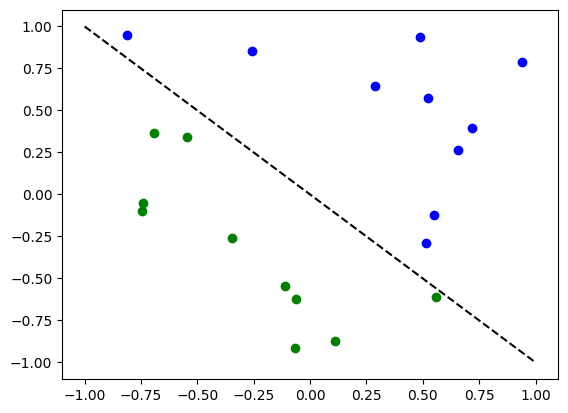

In [2]:
# 特徴数を2（つまり2次元データ）に設定
num_inputs = 2

# サンプル数を20に設定
num_samples = 20

# （num_inputs × num_samples）の2次元配列Xを定義し、Xに対して[-1, 1]の範囲の乱数を付与（以下ではXを2次元平面とみなし、第1座標をx1、第2座標をx2とする）
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1  # random関数の出力範囲は[0, 1]

# x1とx2の和が0以上であれば1、x1とx2の和が0未満であれば0とする2値ラベルy01を定義
y01 = 1 * (np.sum(X, axis=1) >= 0)  # {0, 1}  # axis=1は配列Xを水平方向の合計を表す。 # ()内の不等号は真偽値を表し、 y01 = 1*True = 1, y01 = 1*False = 0、となる。

# ラベルの値を{0, 1}から{-1, 1}に変換した新しい2値ラベルyを定義
y = 2 * y01 - 1  # {-1, +1}

# ラベルが1の場合は青色の点、ラベルが-1の場合は緑色の点で表示
for x, y_target in zip(X, y):  # zip() 関数は、複数のイテラブル（リスト、タプル、セットなど）から要素を取り出し、対応する要素をペアとしてまとめるために使用されます。まとめられた要素はタプルとして返されます。
    if y_target == 1:          
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")

# 境界線を黒色の点線で表示
plt.plot([-1, 1], [1, -1], "--", color="black")

# グラフの表示
plt.show()

In [11]:
#X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
#print(X)

import numpy as np

# 3行4列の行列を作成
X = np.array([[1, 2, 3, 4],
              [5, 6, 7, 8],
              [9, 10, 11, 12]])

# 行ごとの合計を計算
row_sums = X.sum(axis=1)

# 各行の合計値が0以上かどうかを判定
result = row_sums >= 0

x = 1*True
y = 1*False

#print(result)
#print(x,y)

list1 = [1, 2, 3]
list2 = ['a', 'b', 'c']

for x, y in zip(list1, list2):
    print(x, y)

1 a
2 b
3 c


## 2. EstimatorQNNによる分類

EstimatorQNNによる分類の流れは以下のようになる。

1. QNNCircuitを作成する。
2. 1で作った量子回路を元にEstimatorQNNを作成する。
3. 2.で作ったEstimatorQNNを元にNeuralNetworkClassifierを作成する。
4. NeuralNetworkClassifierの学習、分類を行う。

量子ではない機械学習、例えばディープラーニングと比較すると大まかに以下のような対比になっている。

||ディープラーニング|量子機械学習|
|-|-|-|
|モデル|ニューラルネット|量子回路|
|学習パラメータ|ニューラルネットの重み|量子回路のパラメータ|

### 2.1 QNNCircuit

まず、EstimatorQNNで使用するQNNCircuitを作成する。
量子ビット数を指定することで自動で量子回路を作成することができる。

以降で出てくるインスタンスとはクラス（設計図）から作られた実体を指す。

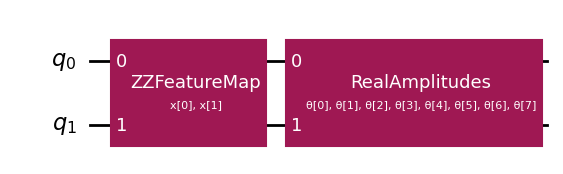

In [19]:
# 2量子ビットの量子回路であるQNNCircuitクラスのインスタンスqcを作成
qc = QNNCircuit(num_qubits=2)

# Matplotlibを用いた量子回路qcの表示（デフォルトではZZFeatureMapとRealAmplitudesなどは複合ゲートとして表示される）
qc.draw(output="mpl")

QNNCircuitはZZFeatureMapとRealAmplitudesの2つの複合ゲートを含む回路になっている。

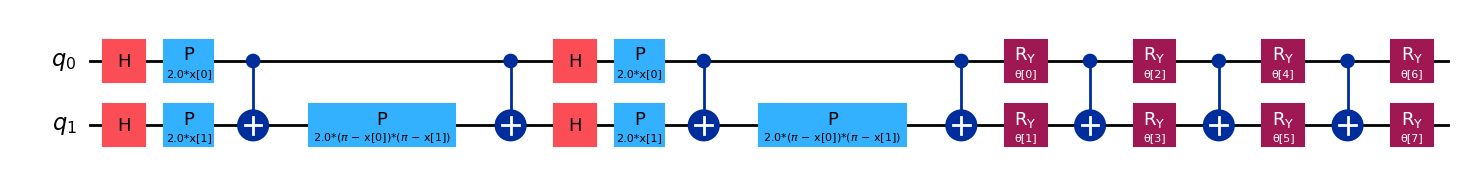

In [21]:
# 複合ゲートを分解して表示
# 分解とは複雑な量子回路をより基本的な量子ゲートに変換する操作のこと
qc.decompose().draw(output="mpl")

ZZFeatureMapは古典的な値を量子コンピュータで使える形にマッピングすることができる特徴量マップである。その他のマッピングとして、PauliFeatureMapなどがある。

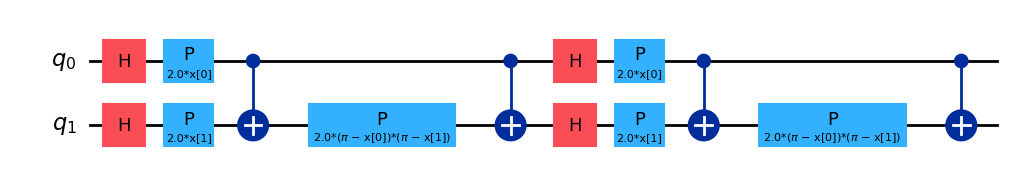

In [22]:
# ZZFeatureMapを分解して表示
ZZFeatureMap(2).decompose().draw(output="mpl")

RealAmplitudesはansatzと呼ばれる量子計算に必要なパラメータ付き量子回路である。その他のansatzとして、EfficeinetSU2などがある。

今回の場合は $\theta[0] \sim \theta[7]$ の8つのパラメータがあり、これを学習パラメータとして分類を行う。

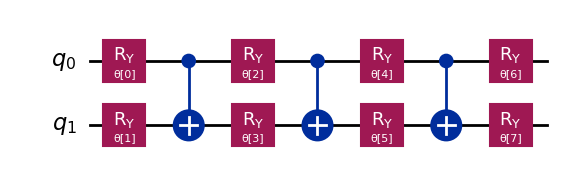

In [23]:
# RealAmplitudesを分解して表示
RealAmplitudes(2).decompose().draw(output="mpl")

### 2.2 EstimatorQNN

In [24]:
# 量子回路qcを基に量子ニューラルネットワークEstimatorQNNのインスタンスestimator_qnnを作成
estimator_qnn = EstimatorQNN(circuit=qc)

# 量子ニューラルネットワークの重みの数を取得
print(estimator_qnn.num_weights)

8


一つの入力の組み(X[0,0],X[0,1])とランダムな重みからestimator_qnnを動かして出力を得る。
EstimatorQNNでは[-1, 1]の値が出力として得られる。

In [25]:
# 乱数で初期化された入力に対して量子ニューラルネットワークが正しく動作するかの確認テスト
estimator_qnn.forward(X[0, :], algorithm_globals.random.random(estimator_qnn.num_weights))

array([[0.03377992]])

モデル学習時の目的関数の変化を見るためのcallback関数を準備する。

In [5]:
# 目的関数の評価値をリストに追加し、反復ごとに値をグラフとして表示
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)  # range関数は、整数の範囲を生成するために使います。 # len関数はリストや文字列の要素数を取得します。
    plt.show()

### 2.3 NeuralNetworkClassifier

estimator_qnnからNeuralNetworkClassifierを作成し、実際に分類器を学習させて分類をおこなう。

学習を行う上で重みをどのように更新するかをNeuralNetworkClassifierに指定することができる。ここではCOBYLAを使用する。

In [27]:
# 作成したestimator_qnnを用いて分類器であるNeuralNetworkClassifierのインスタンスestimator_classifierを作成
# 量子ニューラルネットワークの重みをCOBYLA最適化アルゴリズムにより最適化（最大反復数60）し、学習中の目的関数の評価値をリアルタイムに表示
estimator_classifier = NeuralNetworkClassifier(
    neural_network=estimator_qnn,
    optimizer=COBYLA(maxiter=60),
    callback=callback_graph
)

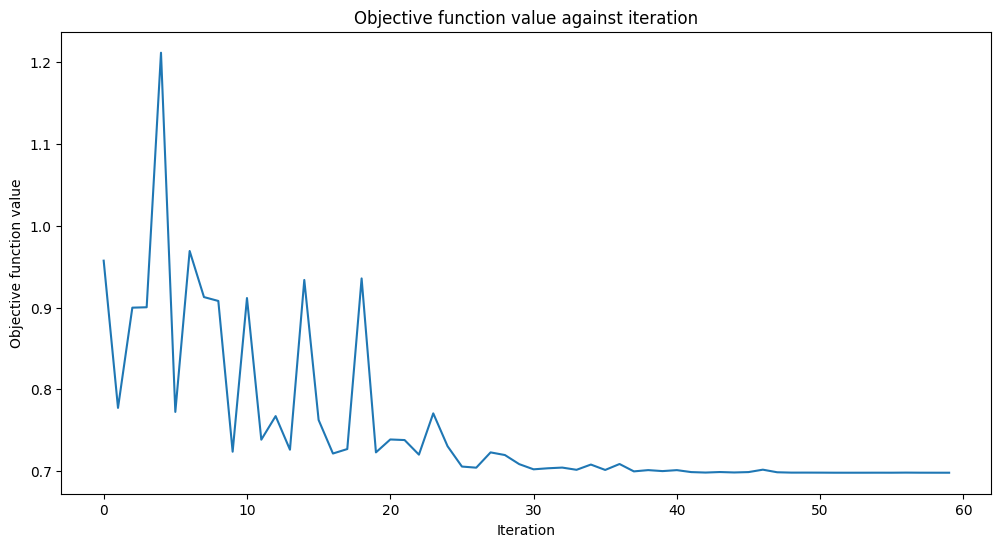

0.7

In [28]:
# 目的関数の評価値を格納するための空の配列を作成
objective_func_vals = []

# グラフのサイズを12（インチ）× 6（インチ）に設定  横 × 縦
plt.rcParams["figure.figsize"] = (12, 6)

# 分類器の学習
# 予測結果は[-1, 1]となるので正解ラベルにはyを使う
estimator_classifier.fit(X, y)

# グラフのサイズを6（インチ）× 4（インチ）に設定
plt.rcParams["figure.figsize"] = (6, 4)

# 分類器の精度を評価
estimator_classifier.score(X, y)

学習させたモデルを使って分類を行う。
予測結果は1もしくは-1の値となる。

In [29]:
# 学習済み分類器によりXに対して2値分類を行う
y_predict = estimator_classifier.predict(X)
y_predict

array([[ 1.],
       [ 1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.]])

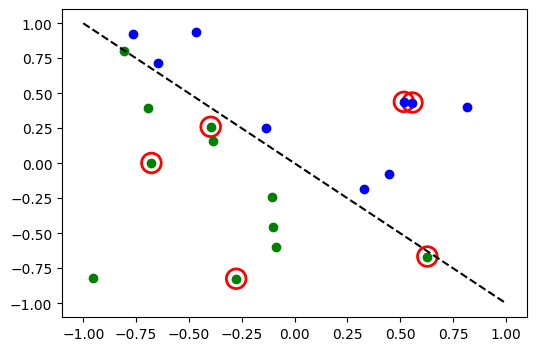

In [30]:
# 誤分類された点は赤い円枠で表示
# 境界線を黒色の点線で表示
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

モデルの自由度はansatzによって決定されており、学習後の重みの値も確認することができる。

In [31]:
# 学習済み分類器の重みを表示
estimator_classifier.weights

array([ 1.56248924,  0.21805461, -0.21303218,  0.22807816,  1.73243365,
        0.11400825,  0.57795091,  0.11732436])

### 2.4 その他の特徴量マップ（PauliFeatureMap）

ここではZZFeatureMapをPauliFeatureMapに変えて同様に分類を行ってみる。

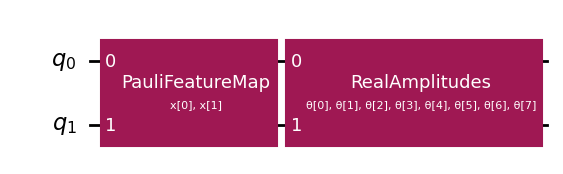

In [33]:
# パウリ行列を用いてデータをエンコードするライブラリPauliFeatureMapの読み込み
from qiskit.circuit.library import PauliFeatureMap

# 特徴量マップとしてパウリ行列XおよびZを指定したPauliFeatureMapを使用し、量子ニューラルネットワーク回路を作成
qc = QNNCircuit(feature_map=PauliFeatureMap(feature_dimension=2, paulis=['X', 'Z']))

# 量子回路の表示
qc.draw(output="mpl")

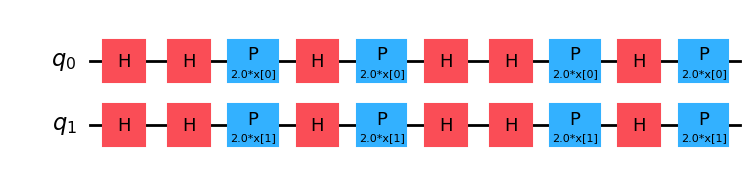

In [34]:
# PauliFeatureMapを分解して表示
PauliFeatureMap(feature_dimension=2, paulis=['X', 'Z']).decompose().draw(output="mpl")

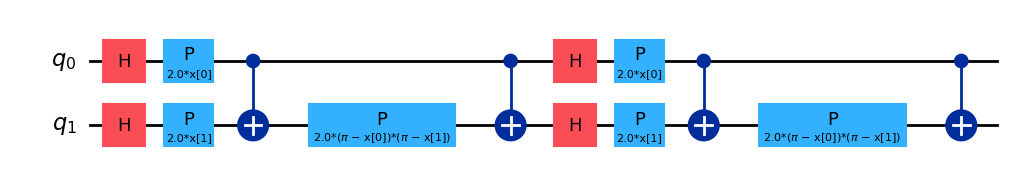

In [35]:
# ZZFeatureMapを分解して表示
ZZFeatureMap(2).decompose().draw(output="mpl")

ZZFeatureMapを使用した場合と同じように学習、分類を行う。

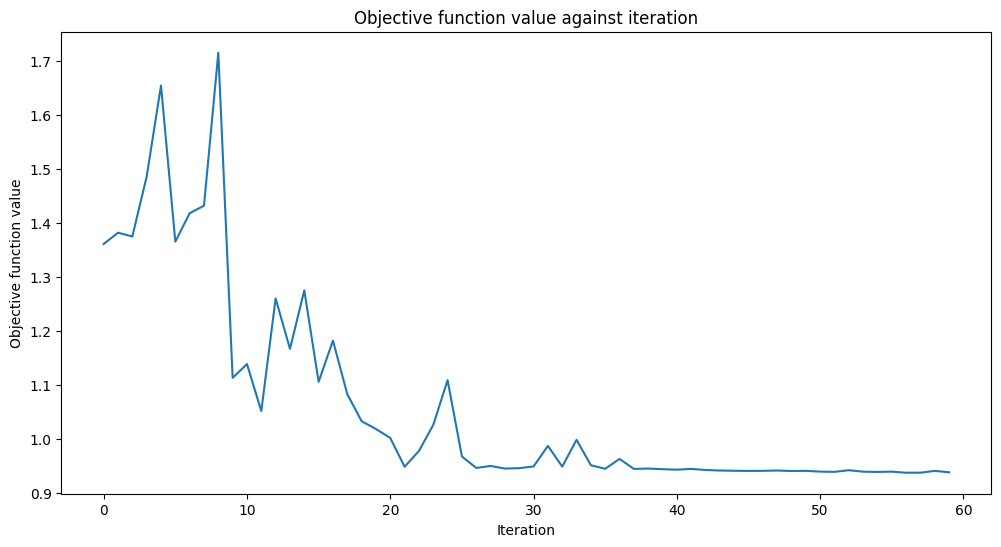

0.75

In [36]:
# 量子回路qcを基にEstimatorQNNのインスタンスestimator_qnnを作成
estimator_qnn = EstimatorQNN(circuit=qc)

# 作成したestimator_qnnを用いてCOBYLAオプティマイザで最適化を行うニューラルネットワーク分類器を作成
# 学習の各ステップにおいて指定されたコールバック関数を使用
estimator_classifier = NeuralNetworkClassifier(
    neural_network=estimator_qnn,
    optimizer=COBYLA(maxiter=60),
    callback=callback_graph
)

# 目的関数の評価値を格納するための空の配列を作成
objective_func_vals = []

# グラフのサイズを12（インチ）× 6（インチ）に設定
plt.rcParams["figure.figsize"] = (12, 6)

# 分類器の学習
estimator_classifier.fit(X, y)

# グラフのサイズを6（インチ）× 4（インチ）に設定
plt.rcParams["figure.figsize"] = (6, 4)

# 分類器の精度を評価
estimator_classifier.score(X, y)

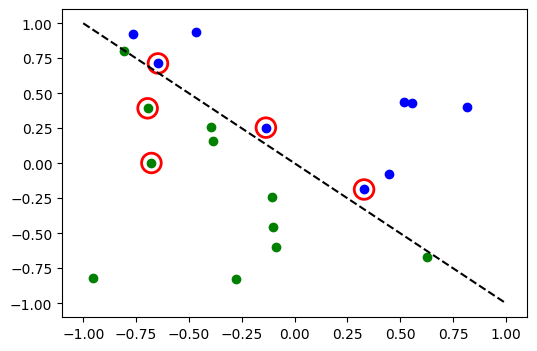

In [37]:
# 学習済み分類器によりXに対して2値分類を行う
y_predict = estimator_classifier.predict(X)

# 誤分類された点は赤い円枠で表示
# 境界線を黒色の点線で表示
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

ZZFeatureMapを使用した場合とは異なる形で分類が行われていることがわかる。

その他にも、ZZFeatureMap自体にentaglementやrepsなどのパラメータを指定することで使用する量子回路を変えることができる。

### 2.5 その他のansatz（EfficientSU2）

ここではRealAmplitudesをEfficientSU2に変えて同様に分類を行ってみる。

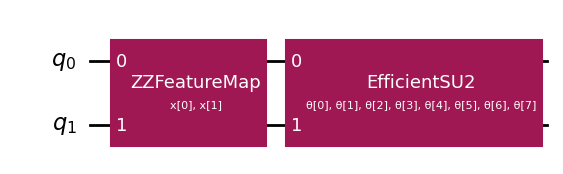

In [38]:
# EfficientSU2の読み込み
from qiskit.circuit.library import EfficientSU2

# 量子ニューラルネットワーク回路（2量子ビット）の作成
qc = QNNCircuit(ansatz=EfficientSU2(2, reps=1))

# 作成した量子回路qcを表示
qc.draw(output="mpl")

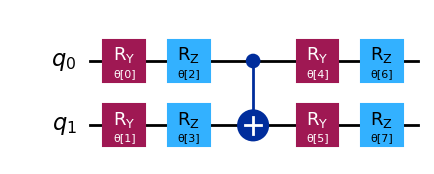

In [39]:
# EfficientSU2を分解して表示
EfficientSU2(2, reps=1).decompose().draw(output="mpl")

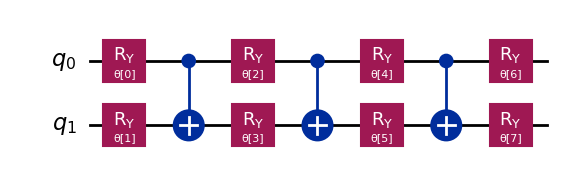

In [40]:
# RealAmplitudesを分解して表示
RealAmplitudes(2).decompose().draw(output="mpl")

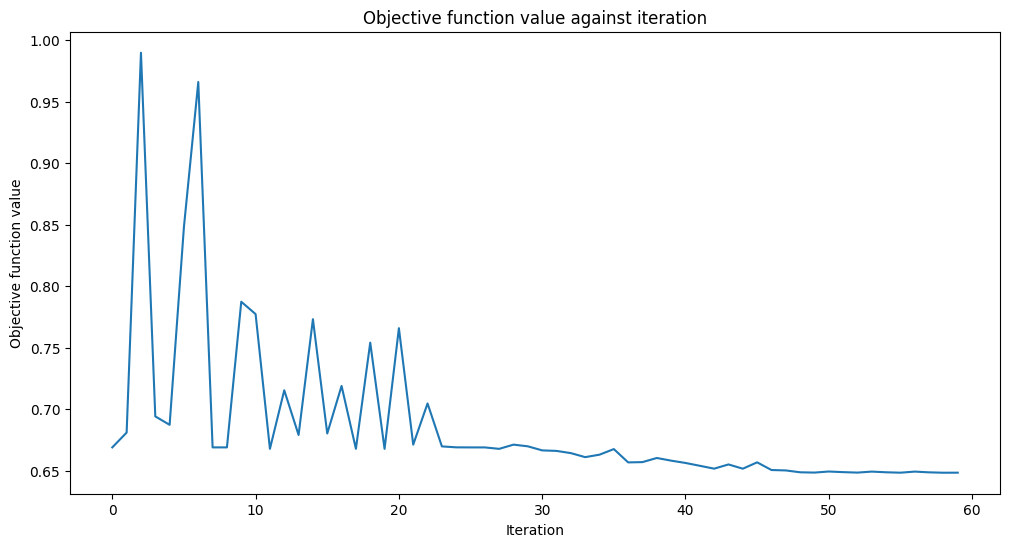

0.75

In [41]:
# 量子回路qcを基にEstimatorQNNのインスタンスestimator_qnnを作成
estimator_qnn = EstimatorQNN(circuit=qc)

# 作成したestimator_qnnを用いてCOBYLAで最適化を行うニューラルネットワーク分類器を作成
# 学習の各ステップにおいて指定されたコールバック関数を使用
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph
)

# 目的関数の評価値を格納するための空の配列を作成
objective_func_vals = []

# グラフのサイズを12（インチ）× 6（インチ）に設定
plt.rcParams["figure.figsize"] = (12, 6)

# 分類器の学習
estimator_classifier.fit(X, y)

# グラフのサイズを6（インチ）× 4（インチ）に設定
plt.rcParams["figure.figsize"] = (6, 4)

# 分類器の精度を評価
estimator_classifier.score(X, y)

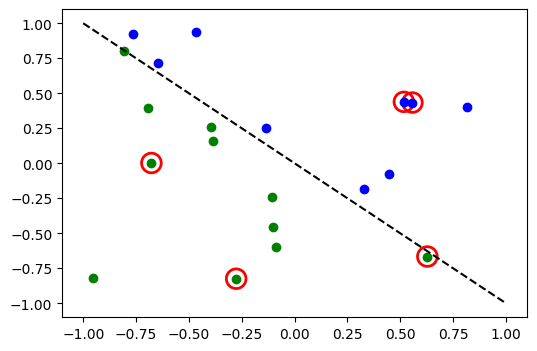

In [42]:
# 学習済み分類器によりXに対して2値分類を実行
y_predict = estimator_classifier.predict(X)

# 正しく分類された点は青または緑で表示し、誤分類された点は赤い円枠で表示
# 境界線を黒色の点線で表示
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

ZZFeatureMapをPauliFeatureMapに変えた時と同じように、RealAmplitudesをEfficientSU2に変えた場合も異なる形で分類が行わていることがわかる。

その他にも、ZZFeatureMap同様RealAmplitudes自体もentaglementやrepsなどのパラメータを指定することで使用する量子回路を変えることができる。

## 3. SamplerQNNによる分類

次に、SamplerQNNを用いた分類を行う。全体の流れはEstimatorQNNと同じである。

1. QNNCircuitを作成する。
2. 1で作った量子回路を元にSamplerQNNを作成する。
3. 2.で作ったSamplerQNNを元にNeuralNetworkClassifierを作成する。
4. NeuralNetworkClassifierの学習、分類を行う。

### 3.1 SamplerQNNとEstimatorQNNの違い

量子コンピュータでは結果は確率的に得られる。

そのため、サイコロを何回も振って期待値を求めたり出やすい目を探すのと同じように、量子コンピュータの計算においても何度も値を測定してそこから期待値や測定結果の分布を求める。
EstimatorQNNの場合は期待値を用いて分類を行っており、SamplerQNNの場合は確率分布を用いて分類を行っている。

### 3.2 QNNCircuit

EstimatorQNNと同様にまずはQNNCircuitを作成する。

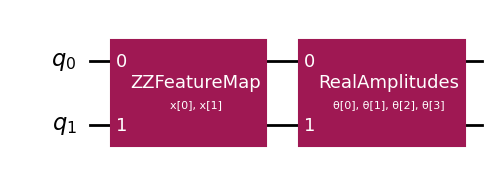

In [48]:
# QNNCircuitクラスのインスタンスqcを作成
# 量子ビット数をnum_inputs、繰り返し数（量子回路の層数）を1に指定
qc = QNNCircuit(ansatz=RealAmplitudes(num_inputs, reps=1))

# Matplotlibを用いた量子回路qcの表示
qc.draw(output="mpl")

### 3.3 SamplerQNN

2値分類を行うために、測定されたビット列から0か1に変換するparity関数を準備する。
ここでは単純に1の数が偶数個か奇数個かで判定する。

In [60]:
# 入力の整数に含まれる1の個数が奇数なのか偶数なのかを判定  # 「1」の個数が偶数→「0」、「1」の個数が奇数→「1」
def parity(x):
    return "{:b}".format(x).count("1") % 2

# クラス数を2に指定
output_shape = 2

In [50]:
# 量子回路qcを基に量子ニューラルネットワークSamplerQNNクラスのインスタンスsampler_qnnを作成
sampler_qnn = SamplerQNN(
    circuit=qc,
    interpret=parity,
    output_shape=output_shape,
)

一つの入力の組み(X[0,0],X[0,1])とランダムな重みからsampler_qnnを動かして出力を得る。
SamplerQNNでは出力は確率分布の形で得られる。

In [51]:
# 乱数で初期化された入力に対して量子ニューラルネットワークが正しく動作するかの確認テスト
sampler_qnn.forward(X[0, :], algorithm_globals.random.random(sampler_qnn.num_weights))

array([[0.54414442, 0.45585558]])

### 3.4 NeuralNetworkClassifier

EstimatorQNNと同じ流れでモデルの学習を行う。

In [54]:
# 作成したsampler_qnnを用いてNeuralNetworkClassifierのインスタンスestimator_classifierを作成
# 量子ニューラルネットワークの重みをCOBYLA最適化アルゴリズムにより最適化（最大反復数30）し、学習中の目的関数の評価値をリアルタイムに表示
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn,
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph
)

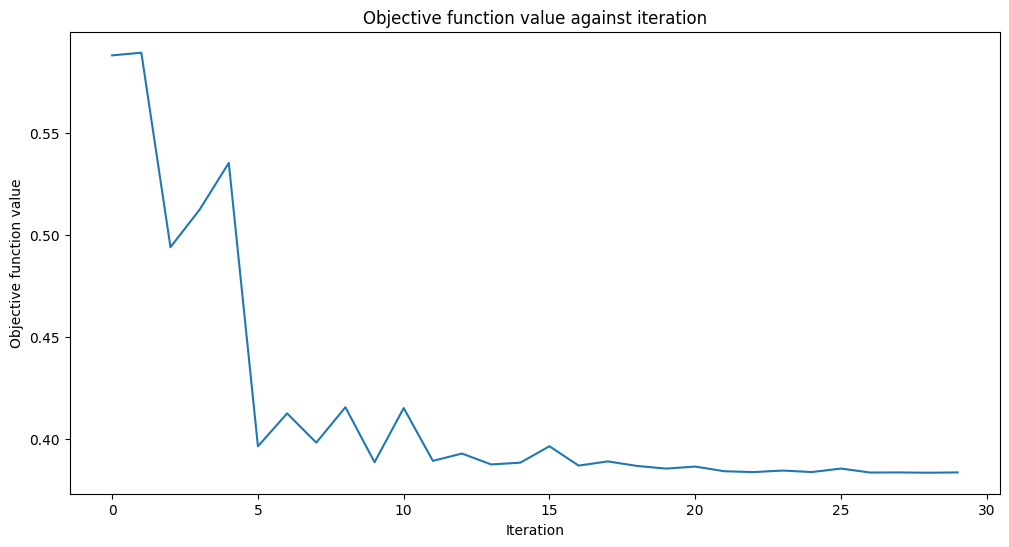

0.65

In [56]:
# 目的関数の評価値を格納するための空の配列を作成
objective_func_vals = []

# グラフのサイズを12（インチ）× 6（インチ）に設定
plt.rcParams["figure.figsize"] = (12, 6)

# 分類器の学習
# 予測結果はそれぞれ[0, 1]となるので正解ラベルにはy01を使う
sampler_classifier.fit(X, y01)

# グラフのサイズを6（インチ）× 4（インチ）に設定
plt.rcParams["figure.figsize"] = (6, 4)

# 分類器の精度を評価
sampler_classifier.score(X, y01)

学習させたモデルを使って分類を行う。
予測結果は0もしくは1の値となる。

In [57]:
# 学習済み分類器によりXに対して2値分類を実行
y_predict = sampler_classifier.predict(X)
y_predict

array([1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1],
      dtype=int64)

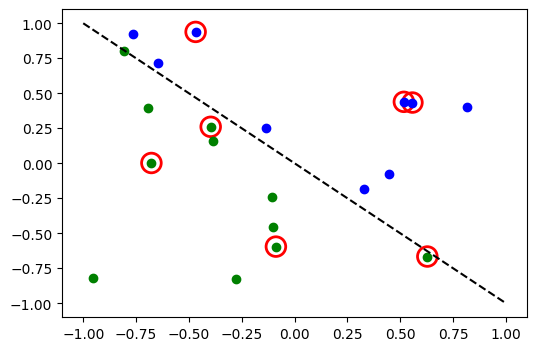

In [58]:
# 誤分類された点は赤い円枠で表示
# 境界線を黒色の点線で表示
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [59]:
# 学習済み分類器の重みを表示
sampler_classifier.weights

array([ 0.04157221,  3.30640038, -0.12220117, -0.29710937])

## 4. Variational Quantum Classifier (VQC)

Variational Quantum Classifier (VQC)はSamplerQNNの特別なバージョンである。

SamplerQNNを作成する際の手順で引数などをVQCの内部で使用されているものに揃えることで同じ分類器を作成することができる。

# 4.1 変分量子分類器 (VQC)

上のSamplerQNNの例と同じようにビット列を分類にマッピングするためにパリティマッピングを適用し、その結果ワンホットエンコーディングとして解釈できる確率ベクトルが得られる。

In [3]:
# num_samples個のサンプルに対してone-hot形式のラベルy_one_hotを定義し、全ての要素を0で初期化
y_one_hot = np.zeros((num_samples, 2))

# one-hotエンコーディング
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1  # 
    #y_one_hot[i, y01[i]]

y_one_hot

print(num_samples, y01, y_one_hot)

20 [1 1 1 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0] [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
import numpy as np
arr = np.zeros(shape, dtype, order)

AI で生成されたコード。ご確認のうえ、慎重にご使用ください。FAQ で詳細を確認。
shape: 新しい配列の形状を指定します。たとえば、(2, 3) のようなタプルを指定できます。
dtype: データ型を指定するパラメータで、オプションです。指定しない場合はデフォルトで numpy.float64 型になります。
order: 配列をメモリに格納する順序を指定します（‘C’ は行優先、‘F’ は列優先）。

例えば、以下のコードで 2 行 3 列の配列を作成できます：

Python

import numpy as np
a = np.zeros((2, 3))

In [6]:
# ZZFeatureMapの作成
feature_map = ZZFeatureMap(num_inputs)

# RealAmplitudes ansatzの作成
ansatz = RealAmplitudes(num_inputs, reps=1)

# VQCのインスタンスvqcを作成
vqc = VQC(
    feature_map=feature_map, # 特徴量マップにの指定
    ansatz=ansatz, # ansatzの指定
    loss="cross_entropy", # 損失関数としてクロスエントロピーを指定
    optimizer=COBYLA(maxiter=30), # 最適化アルゴリズムとして反復関数の最大値30のCOBYLAを指定
    callback=callback_graph, # 学習の各ステップで使用するコールバック関数を指定
)

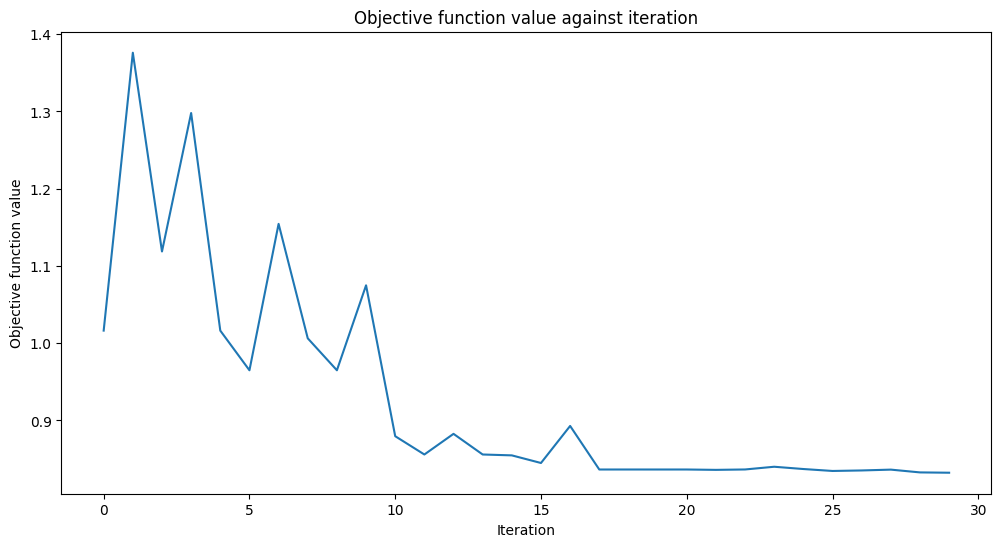

0.6

In [7]:
# 目的関数の評価値を格納するための空の配列を作成
objective_func_vals = []

# グラフのサイズを12（インチ）× 6（インチに設定
plt.rcParams["figure.figsize"] = (12, 6)

# 分類器の学習
# 正解ラベルにはy_one_hotを使う
vqc.fit(X, y_one_hot)

# グラフのサイズを6（インチ）× 4（インチ）に設定
plt.rcParams["figure.figsize"] = (6, 4)

# 分類器の精度を評価
vqc.score(X, y_one_hot)

In [8]:
# 学習済み分類器によりXに対して2値分類を実行
y_predict = vqc.predict(X)
y_predict

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]])

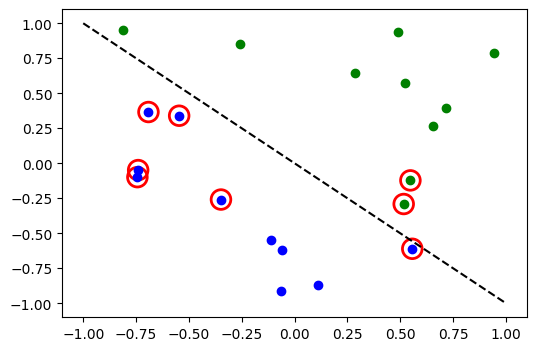

In [9]:
# 誤分類された点は赤い円枠で表示
# 境界線を黒色の点線で表示
for x, y_target, y_p in zip(X, y_one_hot, y_predict):
    if y_target[0] == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

### 4.2. VQC を使用した複数のクラス

クラス数3のデータセットをSciKit-Learnのmake_classificationを用いて作成し、多クラス分類を行う。

- データ数: 10
- 特徴量: 2
- クラス数: 3
- クラスタ: 各クラスごとに1つのクラスタ
- クラス間の分離度: 2.0
- 結果の再現性のため乱数生成器のシードを固定

In [10]:
# classification（分類用サンプルデータセットを生成する関数）の読み込み
from sklearn.datasets import make_classification

# MinMaxScaler（0から1の範囲に規格化するクラス）の読み込み
from sklearn.preprocessing import MinMaxScaler

# make_classificationにより多クラス分類のデータを生成
X, y = make_classification(
    n_samples=10,
    n_features=2,
    n_classes=3,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=2.0,
    random_state=algorithm_globals.random_seed,
)

# Xの値を[0, 1]の範囲に正規化
X = MinMaxScaler().fit_transform(X)

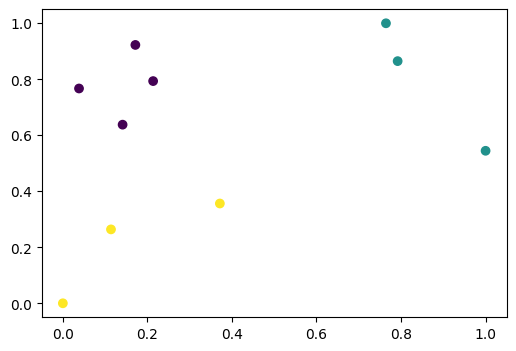

In [11]:
# Xを表示
plt.scatter(X[:, 0], X[:, 1], c=y)

3つのクラスにそれぞれA,B,Cというラベルをつける。

In [12]:
# 整数ラベルのyを文字列のカテゴリカルラベルy_cat（"A", "B", "C"）に変換
y_cat = np.empty(y.shape, dtype=str)
y_cat[y == 0] = "A"
y_cat[y == 1] = "B"
y_cat[y == 2] = "C"

# y_catを表示
print(y_cat)

['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'C']


VQCのインスタンスを作成して学習、分類をする流れは2値分類の場合と同じである。

In [13]:
# VQCクラスのインスタンスvqcを作成
# 量子ビット数を2、A最適化アルゴリズムとしてCOBYLA（最大反復数 30）、学習中にcallback_graphを呼び出し目的関数をリアルタイムに表示
vqc = VQC(
    num_qubits=2,
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph,
)

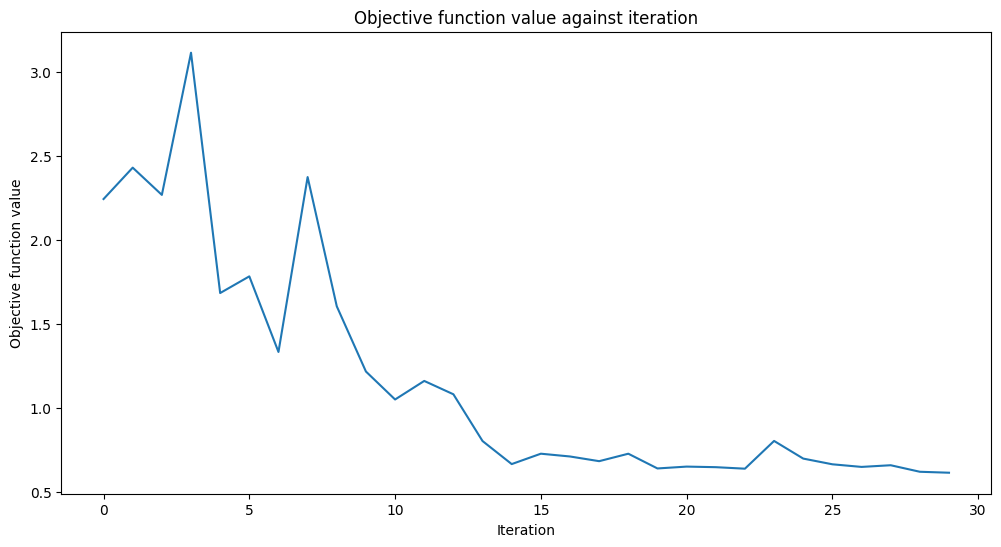

0.9

In [14]:
# 目的関数の評価値を格納するための空の配列を作成
objective_func_vals = []

# グラフのサイズを12（インチ）× 6（インチ）に設定
plt.rcParams["figure.figsize"] = (12, 6)

# 分類器の学習
vqc.fit(X, y_cat)

# グラフのサイズを6（インチ）× 4（インチ）に設定
plt.rcParams["figure.figsize"] = (6, 4)

# 分類器の精度を評価
vqc.score(X, y_cat)

反復回数が少なかったにも関わらず、今回の場合はよい精度を実現することができた。

In [15]:
# 学習済み分類器によりXに対する3クラス分類を実行
predict = vqc.predict(X)

# 予測値と正解データを表示
print(f"Predicted labels: {predict}")
print(f"Ground truth:     {y_cat}")

Predicted labels: ['A' 'A' 'B' 'C' 'A' 'A' 'B' 'B' 'A' 'C']
Ground truth:     ['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'C']


本チュートリアルはQiskitのチュートリアルである[ニューラル・ネットワーク分類器と回帰器](https://qiskit-community.github.io/qiskit-machine-learning/locale/ja_JP/tutorials/02_neural_network_classifier_and_regressor.html)を参考にしている。ただし、Qiskitの最新バージョンとは異なるためチュートリアルのコードがそのまま動かないことやリンクが切れている可能性があることに注意する。

This code is a part of Qiskit

© Copyright IBM 2017, 2023.

This code is licensed under the Apache License, Version 2.0. You may
obtain a copy of this license in the LICENSE.txt file in the root directory
of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.

Any modifications or derivative works of this code must retain this
copyright notice, and modified files need to carry a notice indicating
that they have been altered from the originals.